In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2


In [5]:
class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[1]
        
        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)
        
    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)

        return mask

In [104]:
class Dendrite:
    def __init__(self, soma, depth, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []  

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r**i for i in range(self.depth))
        
        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r**i
        
        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(-num_soma_points // (100 // self.n_primary_dendrites // 1.5), 
                                           (100 // self.n_primary_dendrites // 1.5) + 1, 
                                           size=self.n_primary_dendrites)
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.001
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)
    
    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)
        
        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys
            
        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2
        
        return perturb_xs, perturb_ys


    def _grow_branch(self, x, y, angle, depth):
        if depth == 0:
            return

        length = self.branch_lengths[len(self.branch_lengths) - depth]
        
        if self.weave_type == 'Gauss':
            length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)
        
        end_x = x + length * np.cos(angle)
        end_y = y + length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, length)
        
        self.dendrite_list.append([np.array([weave_x, weave_y]), length, depth])

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            self._grow_branch(end_x, end_y, new_angle, depth - 1)

    def draw(self, color):
            for branch in self.dendrite_list:
                points = branch[0]
                #thickness = branch[3]  # Extract thickness for drawing
                num_points = len(points[0])

                for i in range(num_points - 1):
                    plt.plot(points[0][i:i+2], points[1][i:i+2], color=color, linewidth=1)
    
    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch[0]  # Get the array of points (weave_x, weave_y)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=1)

        return mask

In [99]:
class Neuron:
    def __init__(self, position, depth, mean_soma_radius, std_soma_radius, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4, network=None, neuron_id = None):
        
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.dendrite = Dendrite(self.soma, depth, D, branch_angle, mean_branches, weave_type, randomness, curviness, curviness_magnitude, n_primary_dendrites)
        self.mask = None
        self.neuron_id = neuron_id  # Add neuron_id attribute
        
    def generate_branches(self):
        start_points = self.dendrite._generate_dendrite_start_points()
        
        for start_point in start_points:
                # Start each primary dendrite with a new current_length of 0
            initial_angle = np.arctan2(start_point[1] - self.position[1], start_point[0] - self.position[0])
            self.dendrite._grow_branch(start_point[0], start_point[1], initial_angle, self.dendrite.depth)

    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def connect_branches(self, other_neuron=None, connection_threshold=5.0):
        dendrite_list = self.dendrite.dendrite_list  # Use the single consistent entity

        if other_neuron is None:
            for i, branch1 in enumerate(dendrite_list):
                for j, branch2 in enumerate(dendrite_list):
                    if i != j:
                        dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                        if dist < connection_threshold:
                            if len(branch1) > 3 and len(branch2) > 3:  # Check lengths before assignment
                                if branch1[2] < branch2[2]:
                                    branch1[3] = 0
                                else:
                                    branch2[3] = 0
        else:
            other_branches = other_neuron.dendrite.dendrite_list
            for branch1 in dendrite_list:
                for branch2 in other_branches:
                    dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                    if dist < connection_threshold:
                        if len(branch1) > 3 and len(branch2) > 3:  # Check lengths before assignment
                            if branch1[2] < branch2[2]:
                                branch1[3] = 0
                            else:
                                branch2[3] = 0
    
    def generate_binary_mask(self):
        soma_mask = self.soma.create_binary_mask()
        dendrite_mask = self.dendrite.create_binary_mask()
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8) 
        return self.neuron_mask

In [100]:
class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = None
        self.network_id = network_id

    def _seed_neurons(self):
        for neuron_index in range(self.num_neurons):
            position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
            neuron_id = f"{self.network_id}_{neuron_index}"
            neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)
            self.neurons.append(neuron)
            neuron.generate_branches()
            neuron.connect_branches()

    def _simulate_connections(self):
        for i, neuron in enumerate(self.neurons):
            for j in range(i + 1, len(self.neurons)):
                neuron.connect_branches(self.neurons[j])

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])        
    
        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)
            
        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        # Use the network ID as the header
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        # Add each neuron with its ID and mask to the DataFrame
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

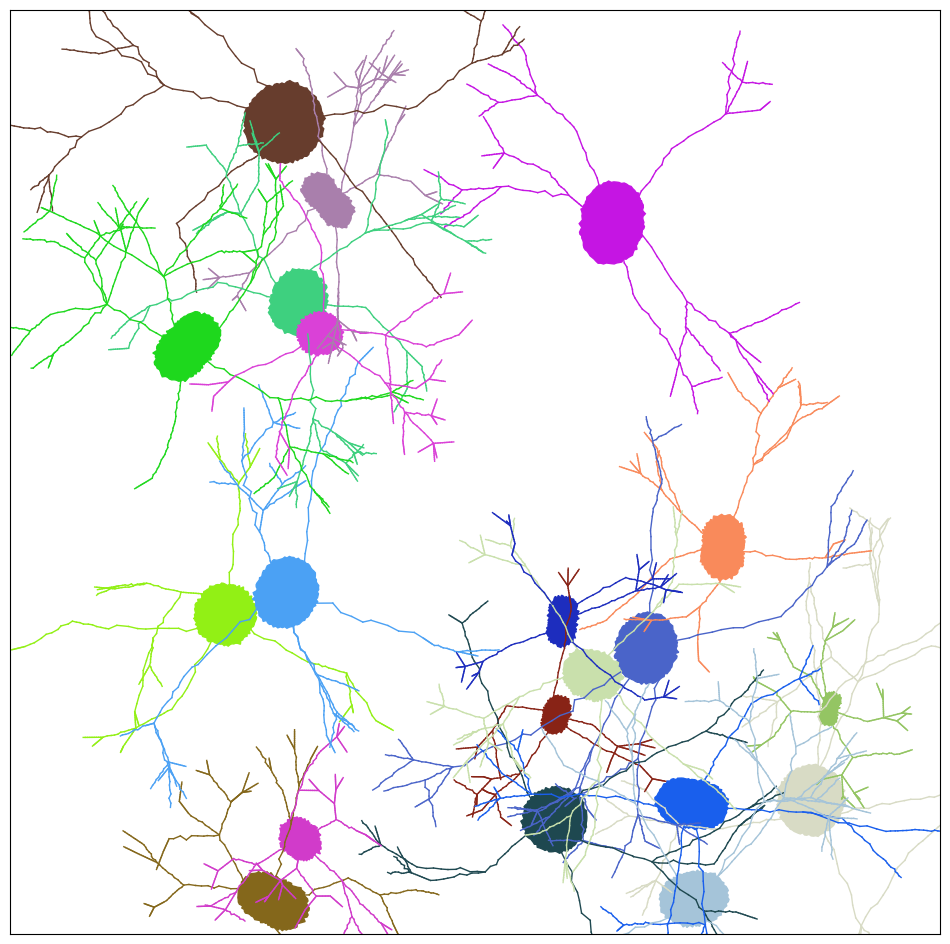

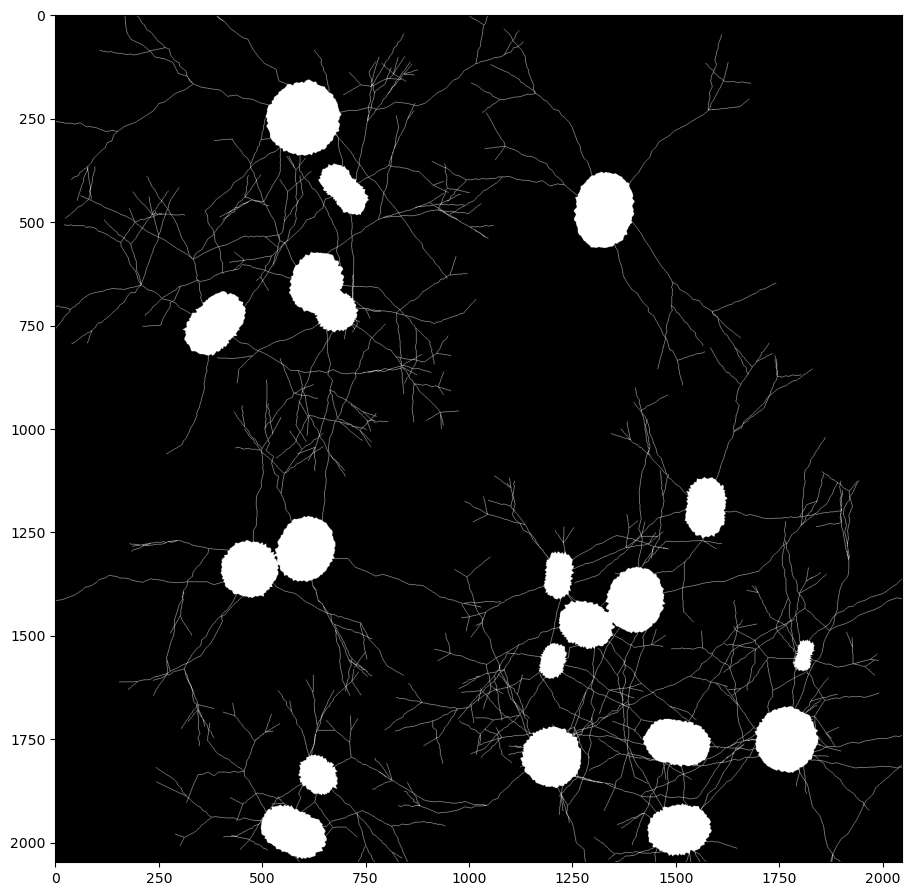

In [107]:
# Parameters
network_width = 2048
network_height = 2048
num_neurons = 20

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 4,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.2,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.3,
    'curviness': 'Gauss',
    'curviness_magnitude': 1,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params, 'nn0')
network._seed_neurons()
network._simulate_connections()

# Draw the network
network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11,11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.show()


In [88]:
nn0_df = network.create_dataframe()
print(nn0_df)

                                    nn0_network_mask  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_0  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_1  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_3  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_4  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_5  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_6  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_7  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

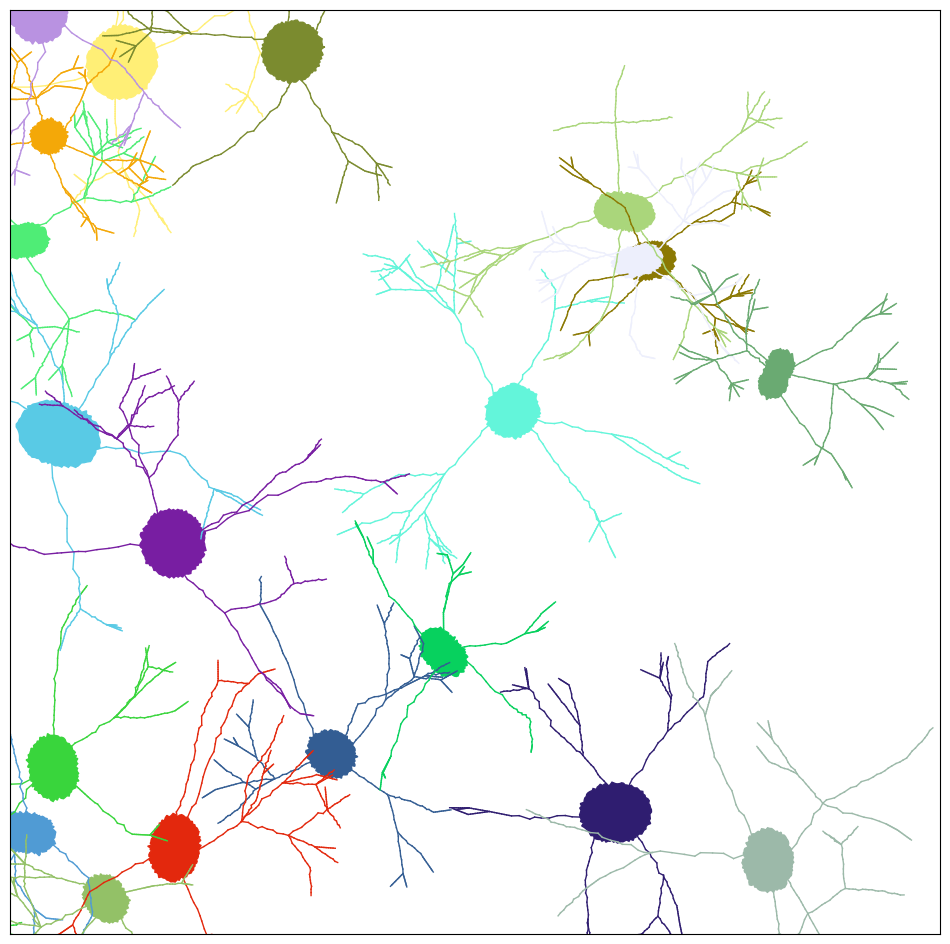

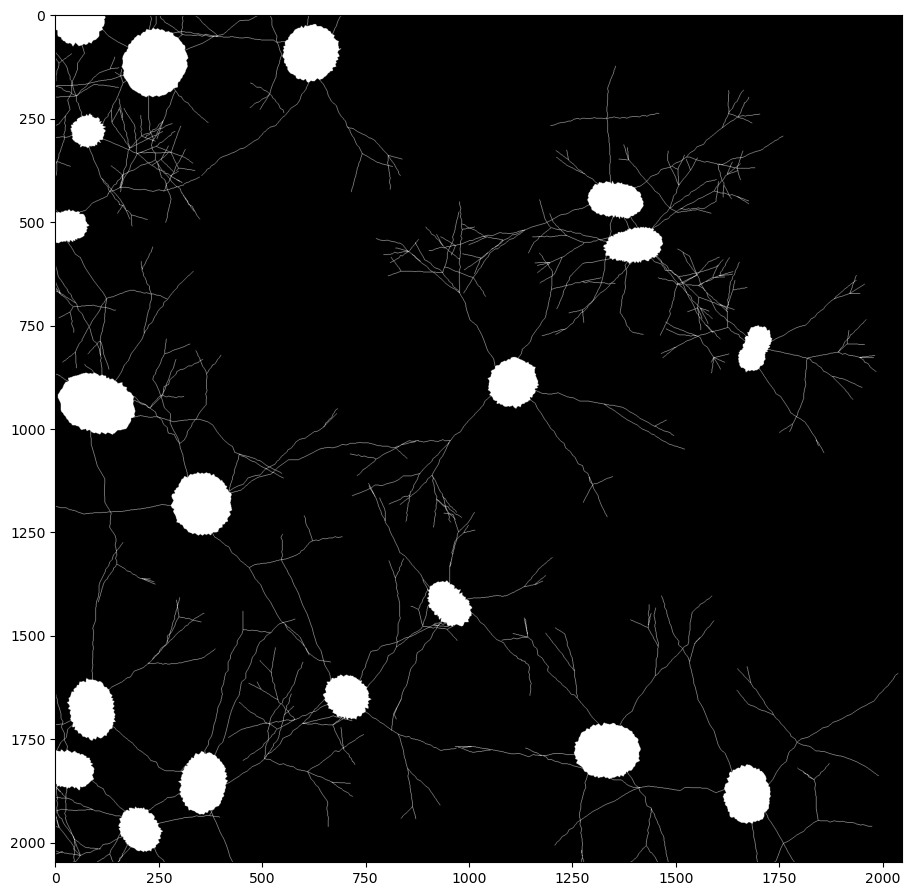

                                    nn0_network_mask  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_0  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_1  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_3  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_4  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_5  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_6  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                               nn0_7  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[1]
        
        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)
        
    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask

class Dendrite:
    def __init__(self, soma, depth, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []  

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r**i for i in range(self.depth))
        
        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r**i
        
        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(-num_soma_points // (100 // self.n_primary_dendrites // 1.5), 
                                           (100 // self.n_primary_dendrites // 1.5) + 1, 
                                           size=self.n_primary_dendrites)
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.001
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)
    
    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)
        
        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys
            
        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2
        
        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth):
        if remaining_depth == 0:
            return []

        length = self.branch_lengths[self.depth - remaining_depth]
        
        if self.weave_type == 'Gauss':
            length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)
        
        end_x = x + length * np.cos(angle)
        end_y = y + length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, length)
        
        self.dendrite_list.append([np.array([weave_x, weave_y]), length, self.depth - remaining_depth])

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            new_branches.append(((end_x, end_y), new_angle))

        return new_branches

    def draw(self, color):
        for branch in self.dendrite_list:
            points = branch[0]
            num_points = len(points[0])

            for i in range(num_points - 1):
                plt.plot(points[0][i:i+2], points[1][i:i+2], color=color, linewidth=1)
    
    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch[0]
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=1)

        return mask

class Neuron:
    def __init__(self, position, depth, mean_soma_radius, std_soma_radius, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4, network=None, neuron_id = None):
        
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.dendrite = Dendrite(self.soma, depth, D, branch_angle, mean_branches, weave_type, randomness, curviness, curviness_magnitude, n_primary_dendrites)
        self.mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.start_points = None
        self.branch_ends = []

    def generate_start_points(self):
        self.start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [(point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0])) for point in self.start_points]

    def grow_layer(self):
        if self.current_depth >= self.dendrite.depth:
            return False

        new_branch_ends = []
        for start_point, angle in self.branch_ends:
            branches = self.dendrite._grow_branch(start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth)
            new_branch_ends.extend(branches)

        self.branch_ends = new_branch_ends
        self.current_depth += 1
        return True

    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def connect_branches(self, other_neuron=None, connection_threshold=5.0):
        dendrite_list = self.dendrite.dendrite_list

        if other_neuron is None:
            for i, branch1 in enumerate(dendrite_list):
                for j, branch2 in enumerate(dendrite_list):
                    if i != j:
                        dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                        if dist < connection_threshold:
                            if len(branch1) > 3 and len(branch2) > 3:
                                if branch1[2] < branch2[2]:
                                    branch1[3] = 0
                                else:
                                    branch2[3] = 0
        else:
            other_branches = other_neuron.dendrite.dendrite_list
            for branch1 in dendrite_list:
                for branch2 in other_branches:
                    dist = np.linalg.norm(np.array(branch1[1]) - np.array(branch2[1]))
                    if dist < connection_threshold:
                        if len(branch1) > 3 and len(branch2) > 3:
                            if branch1[2] < branch2[2]:
                                branch1[3] = 0
                            else:
                                branch2[3] = 0
    
    def generate_binary_mask(self):
        soma_mask = self.soma.create_binary_mask()
        dendrite_mask = self.dendrite.create_binary_mask()
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8) 
        return self.neuron_mask

class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = None
        self.network_id = network_id

    def _seed_neurons(self):
        for neuron_index in range(self.num_neurons):
            position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
            neuron_id = f"{self.network_id}_{neuron_index}"
            neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)
            self.neurons.append(neuron)
            neuron.generate_start_points()

    def grow_network(self):
        growing = True
        while growing:
            growing = False
            for neuron in self.neurons:
                if neuron.grow_layer():
                    growing = True
            self._simulate_connections()

    def _simulate_connections(self):
        for i, neuron in enumerate(self.neurons):
            for j in range(i + 1, len(self.neurons)):
                neuron.connect_branches(self.neurons[j])

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])        
    
        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)
            
        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

# Parameters
network_width = 2048
network_height = 2048
num_neurons = 20

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 4,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.2,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.3,
    'curviness': 'Gauss',
    'curviness_magnitude': 1,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params,'nn0')
network._seed_neurons()
network.grow_network()

# Draw the network
network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11,11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.show()

nn0_df = network.create_dataframe()
print(nn0_df) 